In [29]:
import pandas as pd ## csv파일 불러오는 용도
import numpy as np ## 데이터 처리용
from sklearn.preprocessing import MinMaxScaler ## 스케일러

In [30]:
df = pd.read_csv('005930.KS.csv',usecols=['Open','High','Low','Close','Volume'])
df.head()

,Open,High,Low,Close,Volume
0,26800.0,26800.0,26540.0,26600.0,8774950.0
1,26720.0,26720.0,26260.0,26660.0,10139500.0
2,26300.0,26340.0,25760.0,25900.0,15235500.0
3,25880.0,26220.0,25640.0,26140.0,14322750.0
4,26780.0,26780.0,26200.0,26280.0,14477600.0


In [31]:
df.dropna(inplace=True)

In [32]:
input_feature = ['Open','High','Low','Volume']
target_feature = ['Close']
cols = input_feature+target_feature

scaler = MinMaxScaler()
scaled_arr = scaler.fit_transform(df[cols])
scaled_arr

array([[0.11919369, 0.1168717 , 0.13084112, 0.1356644 , 0.11699288],
       [0.11744084, 0.11511424, 0.12461059, 0.15676092, 0.1183274 ],
       [0.10823839, 0.10676626, 0.11348465, 0.23554721, 0.10142349],
       ...,
       [0.97151621, 0.98242531, 0.9799733 , 0.35502982, 0.96663701],
       [0.93645925, 0.9516696 , 0.96217178, 0.25649283, 0.96218861],
       [0.93207713, 0.96045694, 0.96217178, 0.23296814, 0.96441281]])

In [33]:
def make_mlp_data(arr,window_size,pred_t,time_step=True): ## 몇일전꺼까지 볼건지에 따른 데이터 변환
    raw_X = arr[:,:4]
    raw_Y = arr[:,4]
    temp = window_size+pred_t
    X = []
    for i in range(raw_X.shape[0]-temp):
        subset = raw_X[i:(i+temp-1)]
        X.append(subset.reshape(-1))

    X = np.array(X)
    Y = raw_Y[temp:]
    return X,Y

In [34]:
window_size = 10
t_step = 1
X,y = make_mlp_data(scaled_arr,window_size,t_step)## 10일전꺼까지, 만약 0을 1이나 2로 바꿀 경우 하루뒤, 이틀뒤 값을 예측

In [35]:
X.shape,y.shape

((1431, 40), (1431,))

In [36]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import LeakyReLU

In [37]:
## 100개로 학습끝나고 예측할 예정
test_len = 100
train_X, train_y = X[:-100],y[:-100]
test_X, test_y = X[-100:], y[-100:]

# MLP Model

In [38]:
mlp_model = Sequential()
mlp_model.add(Dense(128, input_dim=4*window_size,activation='relu'))
mlp_model.add(Dropout(0.3))
mlp_model.add(Dense(128,activation='relu'))
mlp_model.add(Dropout(0.3))
mlp_model.add(Dense(128,activation='relu'))
mlp_model.add(Dense(1))
mlp_model.compile(loss="mse", optimizer="rmsprop")

In [39]:
early_stopping = EarlyStopping(patience=5)
mlp_model.fit(train_X,train_y,epochs=100,batch_size=64,validation_split=0.8,shuffle=True,callbacks=[early_stopping])

Epoch 1/100
5/5 [==============================] - 0s 18ms/step - loss: 0.0080 - val_loss: 0.0378
Epoch 2/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0175
Epoch 3/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 4/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 5/100
5/5 [==============================] - 0s 16ms/step - loss: 0.0012 - val_loss: 0.0186
Epoch 6/100
5/5 [==============================] - 0s 5ms/step - loss: 9.6265e-04 - val_loss: 0.0015
Epoch 7/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 0.0268
Epoch 8/100
5/5 [==============================] - 0s 5ms/step - loss: 7.5622e-04 - val_loss: 0.0069


# LSTM Model

In [40]:
train_X = np.reshape(train_X,(-1,window_size,4))

In [41]:
lstm_model = Sequential()
lstm_model.add(LSTM(128, input_shape = (window_size, 4)))
lstm_model.add(Dense(1))
lstm_model.compile(loss="mse", optimizer="adam")

In [42]:
early_stopping = EarlyStopping(patience=5)
lstm_model.fit(train_X,train_y,epochs=100,batch_size=64,validation_split=0.7,shuffle=True,callbacks=[early_stopping])

Epoch 1/100
7/7 [==============================] - 0s 33ms/step - loss: 0.0042 - val_loss: 0.0081
Epoch 2/100
7/7 [==============================] - 0s 9ms/step - loss: 0.0012 - val_loss: 0.0325
Epoch 3/100
7/7 [==============================] - 0s 9ms/step - loss: 7.2745e-04 - val_loss: 0.0020
Epoch 4/100
7/7 [==============================] - 0s 9ms/step - loss: 5.6502e-04 - val_loss: 0.0014
Epoch 5/100
7/7 [==============================] - 0s 9ms/step - loss: 3.7805e-04 - val_loss: 0.0015
Epoch 6/100
7/7 [==============================] - 0s 9ms/step - loss: 3.3069e-04 - val_loss: 0.0040
Epoch 7/100
7/7 [==============================] - 0s 9ms/step - loss: 3.2188e-04 - val_loss: 0.0015
Epoch 8/100
7/7 [==============================] - 0s 9ms/step - loss: 3.2731e-04 - val_loss: 0.0019
Epoch 9/100
7/7 [==============================] - 0s 9ms/step - loss: 2.9707e-04 - val_loss: 0.0018


# test할 100개를 예측

In [43]:
## mlp 모델
pred_y = mlp_model.predict(test_X)
inv_pred_y = scaler.inverse_transform(np.hstack((np.zeros((pred_y.shape[0],4)),pred_y)))[:,4]
inv_test_y = scaler.inverse_transform(np.hstack((np.zeros((pred_y.shape[0],4)),test_y.reshape(-1,1))))[:,4]

In [44]:
inv_pred_y ## 예측값

array([46269.01955605, 47052.08045006, 46824.38645363, 47615.37694931,
       47640.65841675, 48171.63086891, 48187.21673012, 48011.96958542,
       48279.68140602, 47708.20876122, 48681.71408653, 48707.26621628,
       48934.60379601, 48845.21555901, 49186.93074226, 48576.4023304 ,
       49006.62676811, 49640.82875252, 49681.33966446, 49419.55293655,
       50103.80332947, 50225.1431179 , 49890.29632568, 50318.63148689,
       49353.70160103, 51181.82718277, 52154.37045097, 51627.40433693,
       51289.02821541, 51510.2316761 , 51767.82179832, 50553.63336563,
       51629.06046867, 52448.42226982, 52262.30843544, 52468.27173233,
       52413.01642418, 52956.62961006, 52233.13854218, 52708.42155457,
       51966.57636642, 51976.64178848, 52362.37309456, 52066.86881065,
       51548.11903954, 51538.15009117, 51804.08786774, 49963.98078918,
       50549.35368538, 51196.617136  , 50096.65355682, 50214.91154671,
       50787.56867409, 50311.21105194, 50063.53896141, 50797.28571892,
      

In [45]:
inv_test_y ## 실제값

array([52400., 52800., 52600., 52900., 53600., 55000., 53400., 53000.,
       52800., 52700., 53400., 53800., 54700., 53800., 54400., 54200.,
       55300., 54700., 54100., 54200., 55600., 58600., 59000., 59000.,
       57900., 56800., 57300., 56900., 58000., 57500., 57800., 58200.,
       59000., 58700., 58000., 58400., 57800., 55400., 55900., 56100.,
       56400., 56400., 55600., 55400., 54000., 54200., 54400., 56400.,
       55600., 56500., 58700., 58400., 59200., 59000., 60400., 61000.,
       61000., 59500., 59300., 59200., 58200., 58600., 57800., 57900.,
       58200., 58200., 58700., 59000., 59900., 59700., 60400., 60900.,
       60900., 60000., 59500., 60000., 60900., 60900., 60100., 60200.,
       60400., 59800., 59000., 58100., 56600., 57400., 58800., 58500.,
       60300., 60100., 60200., 60200., 61300., 61000., 63200., 66300.,
       65700., 64800., 64600., 64700.])

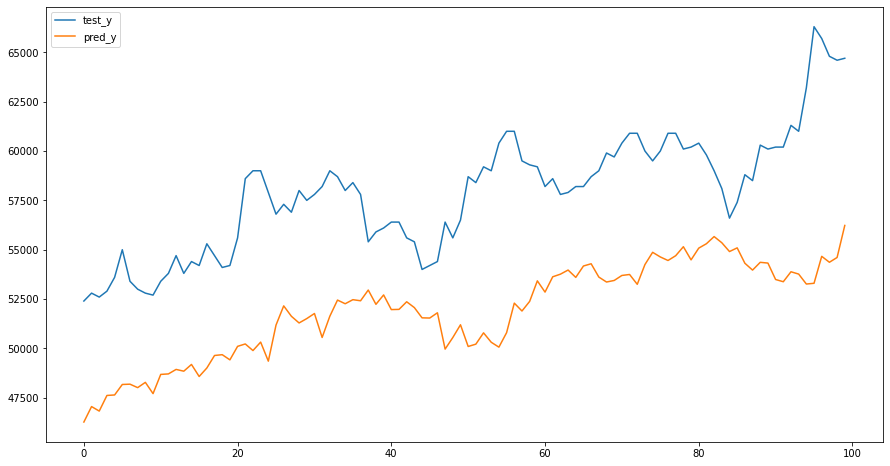

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
plt.plot(inv_test_y,label='test_y')
plt.plot(inv_pred_y,label='pred_y')
plt.legend()
plt.show()

In [47]:
print(f'mean absolute error at mlp model = {np.abs(inv_pred_y-inv_test_y).sum()/len(inv_pred_y)}')

mean absolute error at mlp model = 5953.049744987489


In [48]:
## lstm 모델
test_X = np.reshape(test_X,(-1,window_size,4))
pred_y = lstm_model.predict(test_X)
inv_pred_y = scaler.inverse_transform(np.hstack((np.zeros((pred_y.shape[0],4)),pred_y)))[:,4]
inv_test_y = scaler.inverse_transform(np.hstack((np.zeros((pred_y.shape[0],4)),test_y.reshape(-1,1))))[:,4]

In [49]:
inv_pred_y ## 예측값

array([53358.95171165, 53561.23292923, 53692.02178001, 53942.30937958,
       54069.15084839, 54007.7614212 , 54033.06164742, 54312.81392097,
       54801.82299614, 54947.69122124, 54944.0171814 , 54810.14117241,
       54750.25244713, 54731.97068214, 54981.26674652, 55170.81879616,
       55235.34897804, 55308.69578362, 55566.69859886, 55795.11078835,
       55885.84429741, 55851.65509224, 55973.02167892, 56725.81931114,
       57744.41000938, 58469.63492393, 58951.86672211, 59107.78697014,
       59183.37678909, 59107.03661919, 59160.07035255, 59219.03453827,
       59276.78744316, 59501.45055771, 59568.04688454, 59710.59212685,
       59692.03969955, 59904.25234795, 59998.06765556, 59847.0112896 ,
       59551.95721626, 59110.37032127, 58767.51353264, 58472.69528389,
       58196.37050629, 57929.76813316, 57751.17656708, 57377.32224464,
       57004.26918983, 57074.28765297, 57031.70791626, 57114.93523598,
       57511.42067909, 58035.41218758, 58700.23117065, 59069.9532032 ,
      

In [50]:
inv_test_y ## 실제값

array([52400., 52800., 52600., 52900., 53600., 55000., 53400., 53000.,
       52800., 52700., 53400., 53800., 54700., 53800., 54400., 54200.,
       55300., 54700., 54100., 54200., 55600., 58600., 59000., 59000.,
       57900., 56800., 57300., 56900., 58000., 57500., 57800., 58200.,
       59000., 58700., 58000., 58400., 57800., 55400., 55900., 56100.,
       56400., 56400., 55600., 55400., 54000., 54200., 54400., 56400.,
       55600., 56500., 58700., 58400., 59200., 59000., 60400., 61000.,
       61000., 59500., 59300., 59200., 58200., 58600., 57800., 57900.,
       58200., 58200., 58700., 59000., 59900., 59700., 60400., 60900.,
       60900., 60000., 59500., 60000., 60900., 60900., 60100., 60200.,
       60400., 59800., 59000., 58100., 56600., 57400., 58800., 58500.,
       60300., 60100., 60200., 60200., 61300., 61000., 63200., 66300.,
       65700., 64800., 64600., 64700.])

In [51]:
print(f'mean absolute error at lstm model = {np.abs(inv_pred_y-inv_test_y).sum()/len(inv_pred_y)}')

mean absolute error at lstm model = 1687.8624934196466


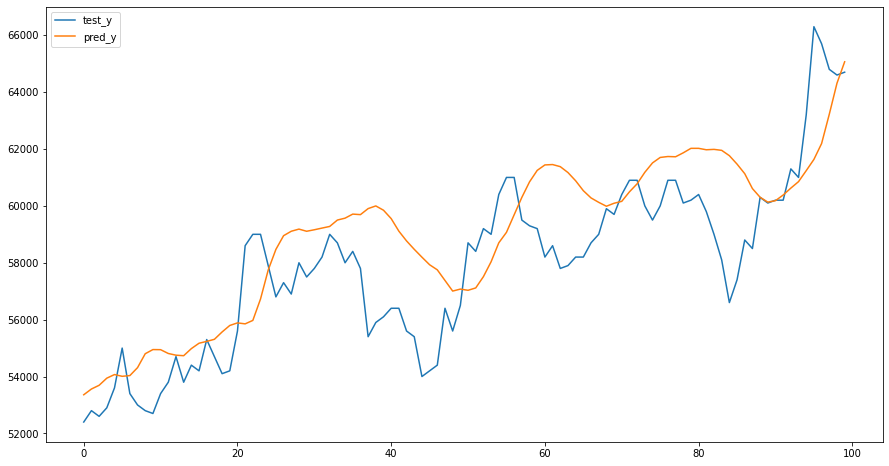

In [52]:
plt.figure(figsize=(15,8))
plt.plot(inv_test_y,label='test_y')
plt.plot(inv_pred_y,label='pred_y')
plt.legend()
plt.show()